# Data acquisition

In [ ]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt


In [ ]:
# read data
# download data folder from https://drive.google.com/drive/folders/15owKpJ3qTAp7jVeC5z_mmFqDwqTKoVO0?usp=sharing
# then upload to colab

!pip install 'openpyxl>=3.0.0'

# read corona data
corona_df = pd.read_excel(r'/content/data/Covid NL.xlsx', engine='openpyxl')
display(corona_df)

# read population data
# there are 3 files, together download not possible from website

tables = pd.read_html(r'/content/data/Deaths_registered_weekly__by_sex_and_age_2018-2019w10.html')
deaths1_df = tables[0]
# display(deaths1_df)

tables = pd.read_html(r'/content/data/Deaths_registered_weekly__by_sex_and_age_2019w11_2020end.html')
deaths2_df = tables[0]
# display(deaths2_df)

tables = pd.read_html(r'/content/data/Deaths_registered_weekly__by_sex_and_age_2021-22.html')
deaths3_df = tables[0]
# display(deaths3_df)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,NLD,Europe,Netherlands,2020-02-27,1,1,NaN,NaN,NaN,NaN,0.058,0.058,NaN,NaN,NaN,NaN,NaN,7.0,0.408,1.0,0.058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,17173094,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,NaN,NaN,NaN,NaN
1,NLD,Europe,Netherlands,2020-02-28,1,0,NaN,NaN,NaN,NaN,0.058,0.000,NaN,NaN,NaN,NaN,NaN,8.0,0.466,9.0,0.524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,17173094,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,NaN,NaN,NaN,NaN
2,NLD,Europe,Netherlands,2020-02-29,6,5,NaN,NaN,NaN,NaN,0.349,0.291,NaN,NaN,NaN,NaN,NaN,9.0,0.524,10.0,0.582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,17173094,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,NaN,NaN,NaN,NaN
3,NLD,Europe,Netherlands,2020-03-01,10,4,NaN,NaN,NaN,NaN,0.582,0.233,NaN,NaN,NaN,NaN,NaN,11.0,0.641,20.0,1.165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,17173094,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,-2332.1,-7.62,-8.61,-135.799641
4,NLD,Europe,Netherlands,2020-03-02,18,8,NaN,NaN,NaN,NaN,1.048,0.466,NaN,NaN,NaN,NaN,NaN,10.0,0.582,34.0,1.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,17173094,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,NLD,Europe,Netherlands,2022-01-23,3898745,65372,45888.000,21289.0,2.0,8.429,227026.359,3806.652,2672.087,1239.672,0.116,0.491,1.51,275.0,16.013,818.0,47.633,68.0,3.960,756.0,44.022,133820.0,24424101.0,1422.231,7.792,135735.0,7.904,0.3381,3.0,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17173094,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,NaN,NaN,NaN,NaN
697,NLD,Europe,Netherlands,2022-01-24,3963375,64630,49070.571,21297.0,8.0,9.143,230789.804,3763.445,2857.410,1240.138,0.466,0.532,1.55,262.0,15.256,879.0,51.185,67.0,3.901,801.0,46.643,150653.0,24574754.0,1431.003,8.773,139364.0,8.115,0.352

# Data cleaning

In [ ]:
# clean missing values from deaths3_df and drop rows with empty values few at end 
deaths3_df = deaths3_df.replace('.', np.nan).dropna()

# Data merging

In [ ]:
# merge 1 and 2 death df
merge12_df = pd.merge(deaths1_df, deaths2_df, how='outer')

# match data types of merge12_df and deaths3_df to allow merge
deaths3_df = deaths3_df.astype(merge12_df.dtypes)

# merge to get complete deaths df
deaths_df = pd.merge(merge12_df, deaths3_df, how='outer')
display(deaths_df)

TopicDeaths                          ...                            
         Unnamed: 0_level_1      Unnamed: 1_level_1  ... Age, 31 December Sex       
                    Periods                 Periods  ...    80 years or older       
                    Periods                 Periods  ...                 Male Female
                    Periods                 Periods  ...               aantal aantal
0               2018 week 1             2018 week 1  ...                  754   1226
1               2018 week 2             2018 week 2  ...                  844   1183
2               2018 week 3             2018 week 3  ...                  799   1159
3               2018 week 4             2018 week 4  ...                  855   1123
4               2018 week 5             2018 week 5  ...                  765   1261
..                      ...                     ...  ...                  ...    ...
207           2021 week 49*           2021 week 49*  ...                 1121   1398
208           2021 week 50*           2021 week 50*  ...                  988   1331
209           2021 week 51*           2021 week 51*  ...                  912   1190
210  2021 week 52 (5 days)*  2021 week 52 (5 days)*  ...                  646    817
211            2022 week 1*            2022 week 1*  ...                  826   1039

[212 rows x 10 columns]

In [ ]:
# fix column index of deaths df
deaths_df.columns = deaths_df.columns.droplevel([0,4])
deaths_df = deaths_df.drop('Unnamed: 1_level_1', axis=1, level=0)
deaths_df.columns = deaths_df.columns.droplevel(0)
deaths_df = deaths_df.rename(columns={'Periods': ''}, level=0)
# display(deaths_df)


In [ ]:
# data transformation

# add columns for sum of male and female
deaths_df['Total', 'Male and Female'] = deaths_df['Total', 'Male'] + deaths_df['Total', 'Female']
deaths_df['0 to 64 years', 'Male and Female'] = deaths_df['0 to 64 years', 'Male'] + deaths_df['0 to 64 years', 'Female']
deaths_df['65 to 79 years', 'Male and Female'] = deaths_df['65 to 79 years', 'Male'] + deaths_df['65 to 79 years', 'Female']
deaths_df['80 years or older', 'Male and Female'] = deaths_df['80 years or older', 'Male'] + deaths_df['80 years or older', 'Female']

deaths_df = deaths_df.sort_index(axis=1)
# display(deaths_df)

In [ ]:
# Clean deaths df Periods column format

pattern = '(\d+) week (\d+)'
periodPattern = re.compile(pattern)

def reformat_period(period: str):
    extracted = periodPattern.match(period).groups()
    year = extracted[0]
    week_nr = extracted[1]
    return str(year) + '-W' + str(week_nr)


deaths_df['', 'Time'] = deaths_df['', 'Periods'].map(reformat_period)
deaths_df = deaths_df.sort_index(axis=1).drop('Periods', level=1, axis=1)
# display(deaths_df)

In [ ]:
# Time colume to index column

deaths_df = deaths_df.set_index(deaths_df['', 'Time']).drop('Time' ,level=1, axis=1)
deaths_df.index.names = ['Time']

# index to date time

def toDateTime(time: str):
    '''day will be first day of the week'''
    # The -1 and -%w pattern tells the parser to pick the Monday in that week.
    return dt.datetime.strptime(time + '-1', "%Y-W%W-%w")

deaths_df.index = deaths_df.index.map(toDateTime)
deaths_df.index = deaths_df.index.shift(6, freq='D')
deaths_df.index.names = ['Week End']
deaths_df['Period'] = pd.PeriodIndex(deaths_df.index, freq='W')
display(deaths_df)

0 to 64 years       ...           Total                 Period
                  Female Male  ... Male and Female                       
Week End                       ...                                       
2018-01-07           160  271  ...            3343  2018-01-01/2018-01-07
2018-01-14           166  240  ...            3359  2018-01-08/2018-01-14
2018-01-21           183  240  ...            3364  2018-01-15/2018-01-21
2018-01-28           163  245  ...            3322  2018-01-22/2018-01-28
2018-02-04           192  264  ...            3403  2018-01-29/2018-02-04
...                  ...  ...  ...             ...                    ...
2021-12-12           218  315  ...            4364  2021-12-06/2021-12-12
2021-12-19           215  260  ...            4036  2021-12-13/2021-12-19
2021-12-26           218  277  ...            3740  2021-12-20/2021-12-26
2022-01-02           158  218  ...            2698  2021-12-27/2022-01-02
2022-01-09           178  270  ...            3392  2022-01-03/2022-01-09

[212 rows x 13 columns]

In [ ]:
# set equal data for before and after corona

# approximate corona start from third month (March) of 2020 and end at 2021 31 December 
corona_start = '2020-03-01'
corona_end = '2021-12-31'
deaths_during_corona = deaths_df[deaths_df.index >= pd.to_datetime(corona_start)]
deaths_during_corona = deaths_during_corona[deaths_during_corona.index <= pd.to_datetime(corona_end)]

# 22 months of corona and before corona each

before_corona_start = '2018-05-01'
# before_corona_end = corona start
deaths_before_corona = deaths_df[deaths_df.index < pd.to_datetime(corona_start)]
deaths_before_corona = deaths_before_corona[deaths_before_corona.index >= pd.to_datetime(before_corona_start)]

In [ ]:
# statictics

print('Before corona:')
display(deaths_before_corona.describe())

print('After corona:')
display(deaths_during_corona.describe())

Before corona:


0 to 64 years              ...        Total                
             Female        Male  ...         Male Male and Female
count     96.000000   96.000000  ...    96.000000       96.000000
mean     166.791667  228.593750  ...  1375.916667     2804.406250
std       24.950864   33.078082  ...   189.679767      385.261622
min       30.000000   36.000000  ...   213.000000      456.000000
25%      158.750000  219.750000  ...  1319.250000     2671.000000
50%      167.000000  230.000000  ...  1368.000000     2790.500000
75%      180.250000  245.250000  ...  1472.500000     3024.250000
max      209.000000  280.000000  ...  1677.000000     3364.000000

[8 rows x 12 columns]

After corona:


0 to 64 years              ...        Total                
             Female        Male  ...         Male Male and Female
count     97.000000   97.000000  ...    97.000000       97.000000
mean     175.216495  247.422680  ...  1621.556701     3234.175258
std       18.997931   25.314618  ...   289.104795      542.075621
min      109.000000  165.000000  ...  1218.000000     2369.000000
25%      163.000000  232.000000  ...  1421.000000     2856.000000
50%      174.000000  245.000000  ...  1547.000000     3072.000000
75%      187.000000  262.000000  ...  1802.000000     3550.000000
max      222.000000  315.000000  ...  2667.000000     5085.000000

[8 rows x 12 columns]

In [ ]:
# updating corona df

corona_df.index = pd.to_datetime(corona_df['date'])
corona_df = corona_df.drop('date', axis = 1)

corona_df = corona_df[corona_df.index >= pd.to_datetime(corona_start)] 
corona_df = corona_df[corona_df.index <= pd.to_datetime(corona_end)]

# display(corona_df)

# Data aggregation and Visualization

In [ ]:
# aggregation of deaths_after_corona
weekly_corona_df = corona_df.resample('W').sum()

deaths_during_corona['new_cases'] = weekly_corona_df['new_cases']
deaths_during_corona['total_cases'] = weekly_corona_df['total_cases']

deaths_during_corona['year'] = deaths_during_corona.index.year
deaths_during_corona['month'] = deaths_during_corona.index.month
deaths_during_corona = deaths_during_corona.reset_index()

monthly_mean_during_corona = deaths_during_corona.groupby(['year', 'month']).sum().groupby('month').mean()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
# aggregation of deaths_before_corona
deaths_before_corona['year'] = deaths_before_corona.index.year
deaths_before_corona['month'] = deaths_before_corona.index.month
deaths_before_corona = deaths_before_corona.reset_index()
monthly_mean_before_corona = deaths_before_corona.groupby(['year', 'month']).sum().groupby('month').mean()


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


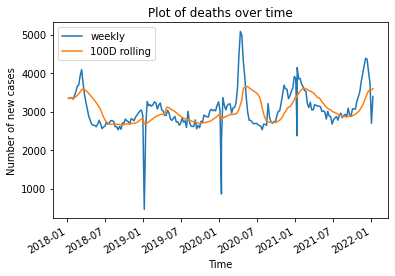

In [ ]:
# visualizing deaths df using movinf window function

ax = deaths_df['Total', 'Male and Female'].plot(label='weekly')
deaths_df['Total', 'Male and Female'].rolling('100D').mean().plot(label='100D rolling')
ax.set_ylabel('Number of new cases')
ax.set_xlabel('Time')
ax.set_title('Plot of deaths over time')
plt.legend(loc='best')


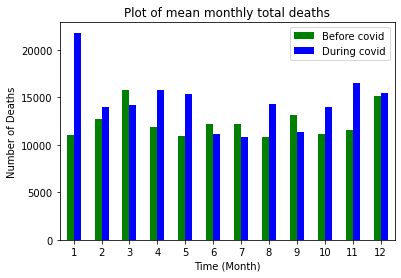

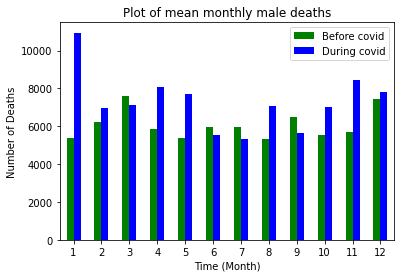

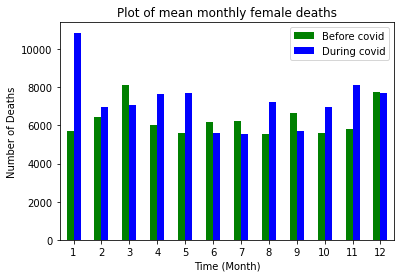

In [ ]:
# plots of mean monthly deaths of all known months

data = pd.concat([monthly_mean_before_corona['Total', 'Male and Female'], monthly_mean_during_corona['Total', 'Male and Female']], axis=1, keys=['Before covid', 'During covid'])
ax = data.plot.bar(color='gb')
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of mean monthly total deaths')
ax.set_xticklabels(data.index , rotation=0)
plt.show()

data = pd.concat([monthly_mean_before_corona['Total', 'Male'], monthly_mean_during_corona['Total', 'Male']], axis=1, keys=['Before covid', 'During covid'])
ax = data.plot.bar(color='gb')
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of mean monthly male deaths')
ax.set_xticklabels(data.index , rotation=0)
plt.show()

data = pd.concat([monthly_mean_before_corona['Total', 'Female'], monthly_mean_during_corona['Total', 'Female']], axis=1, keys=['Before covid', 'During covid'])
ax = data.plot.bar(color='gb')
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of mean monthly female deaths')
ax.set_xticklabels(data.index , rotation=0)
plt.show()


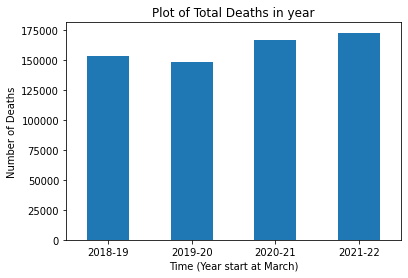

In [ ]:
# plots of total deaths in 2018-2019-20-21

# drop 2022 as incomplete data
data = deaths_df.resample('A-DEC').sum().drop('2022-12-31')['Total', 'Male and Female']

ax = data.plot.bar()
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Year start at March)')
ax.set_title('Plot of Total Deaths in year')
ax.set_xticklabels(['2018-19', '2019-20', '2020-21', '2021-22'], rotation=0)

plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


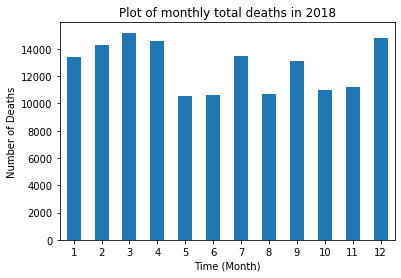

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  # This is added back by InteractiveShellApp.init_path()


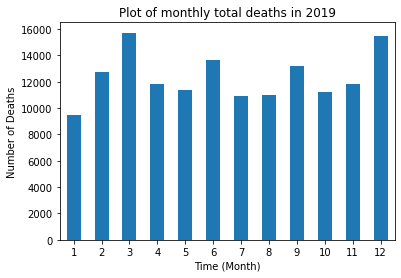

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


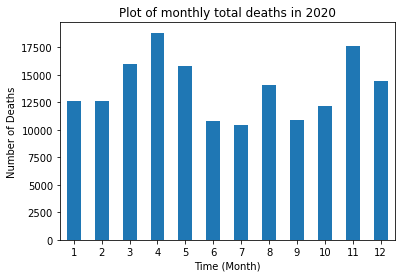

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


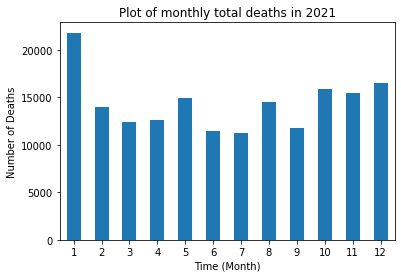

In [ ]:
# compare monthly deaths from previous years

data = deaths_df['2018'].resample('M').sum().set_index(deaths_df['2018'].resample('M').sum().index.month)['Total', 'Male and Female']
ax = data.plot.bar()
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of monthly total deaths in 2018')
ax.set_xticklabels(data.index , rotation=0)
plt.show()

data = deaths_df['2019'].resample('M').sum().set_index(deaths_df['2019'].resample('M').sum().index.month)['Total', 'Male and Female']
ax = data.plot.bar()
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of monthly total deaths in 2019')
ax.set_xticklabels(data.index , rotation=0)
plt.show()

data = deaths_df['2020'].resample('M').sum().set_index(deaths_df['2020'].resample('M').sum().index.month)['Total', 'Male and Female']
ax = data.plot.bar()
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of monthly total deaths in 2020')
ax.set_xticklabels(data.index , rotation=0)
plt.show()

data = deaths_df['2021'].resample('M').sum().set_index(deaths_df['2021'].resample('M').sum().index.month)['Total', 'Male and Female']
ax = data.plot.bar()
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Time (Month)')
ax.set_title('Plot of monthly total deaths in 2021')
ax.set_xticklabels(data.index , rotation=0)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Indexing a DataFrame with a datetimelike index using a single 

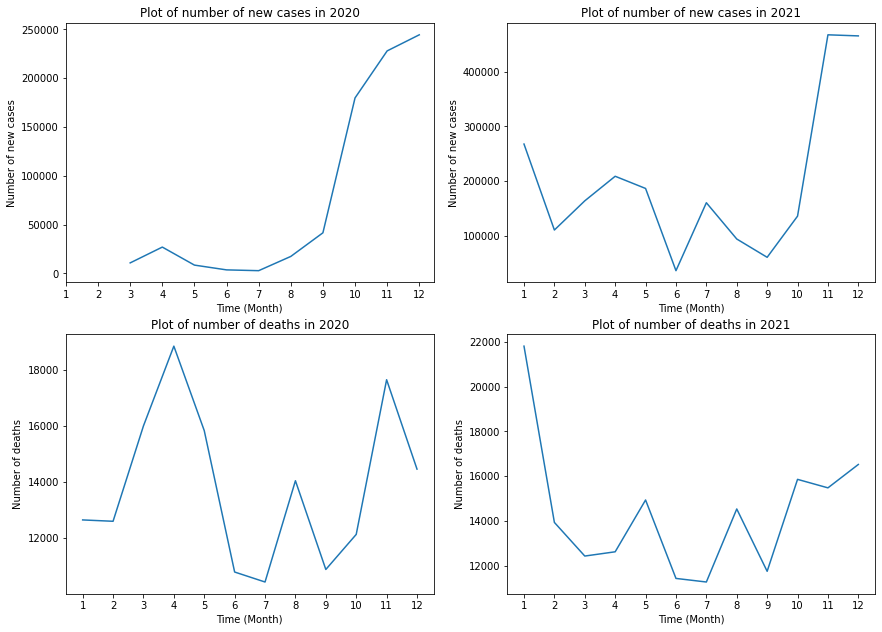

In [ ]:
# plot of relation between new cases and number of deaths

fig = plt.figure()
fig.set_size_inches(14.5, 10.5)

# Note positions of ax2 and ax3 are different
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,2)
ax4 = fig.add_subplot(2,2,4)

data = deaths_during_corona.set_index('Week End').resample('M').sum()['2020']
ax1.plot(data.set_index(data.index.month)['new_cases'])
ax1.set_ylabel('Number of new cases')
ax1.set_xlabel('Time (Month)')
ax1.set_title('Plot of number of new cases in 2020')
ax1.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])


data = deaths_df.resample('M').sum()['2020']
ax2.plot(data.set_index(data.index.month)['Total', 'Male and Female'])
ax2.set_ylabel('Number of deaths')
ax2.set_xlabel('Time (Month)')
ax2.set_title('Plot of number of deaths in 2020')
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])


data = deaths_during_corona.set_index('Week End').resample('M').sum()['2021']
ax3.plot(data.set_index(data.index.month)['new_cases'])
ax3.set_ylabel('Number of new cases')
ax3.set_xlabel('Time (Month)')
ax3.set_title('Plot of number of new cases in 2021')
ax3.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])


data = deaths_df.resample('M').sum()['2021']
ax4.plot(data.set_index(data.index.month)['Total', 'Male and Female'])
ax4.set_ylabel('Number of deaths')
ax4.set_xlabel('Time (Month)')
ax4.set_title('Plot of number of deaths in 2021')
ax4.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])


plt.show()